In [1]:
import numpy as np
import healpy as hp
import matplotlib as mpl
from   matplotlib import cm
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from astropy.constants import h
from astropy.constants import k_B

T_cmb = 2.7255

mpl.rcParams['text.usetex'] = True

In [2]:
def cmb_to_rj(freq,data):
    y          = h.value*(freq*1e9)/ (k_B.value*T_cmb)
    conversion = (y**2.0*np.exp(y))/(np.exp(y)-1)**2.0
    return data*conversion

In [3]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    # Inputs need to be in GHz.
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

In [4]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_Q_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_Q_scaled[i]   = np.nan
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_U_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_U_scaled[i]   = np.nan
        elif (pol == 'P'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_P_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_P_scaled[i]   = np.nan
        else:
            print("Unusable pol type (use 'Q', 'U', or 'P').")
            
def sky_frac(map):
    masked = 0
    for i in range(len(map)):
        if (map[i] == hp.UNSEEN):
            masked += 1
            
    print('Sky fraction: ', 1.-masked/len(map))

In [5]:
def plot_SED():
    fig, ax = plt.subplots(figsize=(6,6))

    # Synch
    ax.fill_between(x,power_law(s_Q_mean,44.0,x,beta_s),power_law(s_U_mean,44.0,x,beta_s),color='gray',alpha=0.2,label='Synch')
#     ax.fill_between(x,power_law(s_P_mean,44.0,x,beta_s-0.01),power_law(s_P_mean,44.0,x,beta_s+0.01),color='gray',alpha=0.2,label='Synch')

 
    # MBB + AME Pol
    ax.plot(x,spdust_tot*(20./22.)+mbb(1.0,353.,x,19.6,1.60),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 20\%$')
    ax.plot(x,spdust_tot*(10./22.)+mbb(1.0,353.,x,19.6,1.60),color=colors[1],label=r'$p_{\mathrm{AME}}^{max} = 10\%$')
    ax.plot(x,spdust_tot*(5./22.)+mbb(1.0,353.,x,19.6,1.60),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 5\%$')
    ax.plot(x,spdust_tot*(1./22.)+mbb(1.0,353.,x,19.6,1.60),color=colors[3],label=r'$p_{\mathrm{AME}}^{max} = 1\%$')
    
    ax.plot(x,mbb(1.0,353.,x,19.6,1.62),color=colors[5],label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB
    ax.fill_between(x,mbb(1.0,353.,x,19.6,beta_d_mean-beta_d_std),mbb(1.0,353.,x,19.5,beta_d_mean+beta_d_std),color=colors[5],alpha=0.2) # Planck 2018 Dust Pol MBB
    
    # Fit dust amplitudes
    k = 0
    ax.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10,label='This work')
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='red',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_U_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-2,2e0])
        ax.set_xlim([10,200.])
    else:
        ax.set_ylim([-0.1,0.1])
        ax.set_xlim([5,100])
    ax.set_xticks([10, 40, 100])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylabel(r'$A/A_{353}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_mean_'+version+'.pdf',dpi=300,bbox_inches='tight')
#     plt.show()    

In [6]:
def fit_ame_2_amps(sdust,mbb,x,amps,freqs,err):
    pols  = np.linspace(0,1,1000)
    chisq = np.empty(1000)
    
    sed_size = len(mbb)
#     print(sed_size)
    
    sig = np.empty((len(mbb),len(chisq)))
    
    
    for i in range(1000):
        sig[i] = mbb+pols[i]*sdust
        for j in range(len(amps)):
            chisq[i] += ((amps[j]-np.interp(freqs[j],x,sig[i]))**2)/(err[j]**2)
     
    indx = np.where(chisq == np.min(chisq))
    pmax = 22*pols
    post = np.exp(-0.5*chisq)
    norm = np.trapz(post,pols)
    
    cumul = np.cumsum(post)
    
    dummy = np.empty(1000)

    xfill = np.where(cumul/cumul[-1] < 0.95)[-1]
    
    return post/norm
        
#     fig, ax = plt.subplots(1,2,figsize=(12,6))
#     ax[0].loglog(x,sig[0])
#     for i in range(10):
#         ax[0].loglog(x,sig[i*100-1])
# #     ax[0].scatter(freqs,amps,color='k')
#     ax[0].errorbar(freqs,amps,err,fmt='.',marker='x',color='k',zorder=10)
#     ax[0].set_xlim([10,100])
#     ax[0].set_ylim([1e-2,1])
#     ax[0].set_xticks([10, 40, 100])
#     ax[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        
#     ax[1].plot(pmax,post/norm)
#     ax[1].set_xlabel(r'$p_{\rm max}\, [{\rm \%}]$',size=20)
#     ax[1].set_ylabel(r'$p(p_{\rm max}\,|A_{\rm d},\,A_{\rm s},\,{\rm d})$',size=20)
# #     ax[1].set_xlim([0,5])
#     ax[1].fill_between(pmax[:xfill[-1]],dummy[:xfill[-1]],post[:xfill[-1]]/norm,color='blue',alpha=0.4,label=r'${\rm 95\,\%\, Confidence\, Interval}$')
# #     ax[1].set_ylim([0,70])
#     plt.rc('ytick',labelsize=20)
#     plt.rc('xtick',labelsize=20)
# #     ax[1].tick_params(axis='x', labelsize=20)
# #     ax[1].tick_params(axis='y', labelsize=20)
#     ax[1].legend(loc=1,prop={'size': 15})
#     fig, ax = plt.subplots(figsize=(6,6))
#     ax.plot(pmax,post/norm)
#     ax.set_xlabel(r'$p_{\rm max}\, [{\rm \%}]$',size=20)
#     ax.set_ylabel(r'$p(p_{\rm max}\,|A_{\rm d},\,A_{\rm s},\,{\rm d})$',size=20)
#     ax.set_xlim([0,20])
#     ax.fill_between(pmax[:xfill[-1]],dummy[:xfill[-1]],post[:xfill[-1]]/norm,color='blue',alpha=0.4,label=r'${\rm 95\,\%\, Confidence\, Interval}$')
#     ax.set_ylim([0,3])
#     plt.rc('ytick',labelsize=20)
#     plt.rc('xtick',labelsize=20)
# #     ax.tick_params(axis='x', labelsize=20)
# #     ax.tick_params(axis='y', labelsize=20)
#     ax.legend(loc=1,prop={'size': 15})

#     plt.savefig('../'+dir+'/P_amp_bestfit_posterior_w_sed_'+version+'.pdf',dpi=300,bbox_inches='tight')
#     plt.show()

In [7]:
def read_params(filename):
    labels = []
    freq   = []
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('NUMBAND'):
                numbands = int(line.split('=')[1])
            if line.startswith('NUMGIBBS'):
                numgibbs = int(line.split('=')[1][:5])
            if line.startswith('COMP_PRIOR_GAUSS_BETA_MEAN01'):
                beta_s = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_TD_MEAN'):
                t_d_mean = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_TD_STD'):
                t_d_std = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_BETA_MEAN'):
                beta_d_mean = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_BETA_STD'):
                beta_d_std = float(str.strip(line.split('=')[1]))
                
    blabs = []
    bfreq = []
    for band in range(numbands):
        blabs.append('BAND_LABEL'+str(band+1).zfill(2))
        bfreq.append('BAND_FREQ'+str(band+1).zfill(2))        
    for band in range(numbands):
         with open(filename,'r') as infile:
            for line in infile:
                if line.startswith(blabs[band]):
                    name = str.strip(line.split('=')[1])
                    labels.append(name)
                if line.startswith(bfreq[band]):
                    fre  = str.strip(line.split('=')[1])
                    freq.append(float(fre))                    
    
    return labels, freq, numgibbs, beta_s, t_d_mean, t_d_std, beta_d_mean, beta_d_std

In [8]:
dir     = str(input('Which directory are we wanting to plot from? '))
version = dir[dir.index('v'):dir.index('v')+3]
print(version)

Which directory are we wanting to plot from?  bp_results_v09


v09


In [9]:
names, freq, num_samp, beta_s, t_d_mean, t_d_std, beta_d_mean, beta_d_std = read_params('../'+dir+'/param_'+dir+'.txt')
labels = [name.replace("'","") for name in names]
labels = [w.replace("_","\_") for w in labels]
num_bands = len(freq)
print(labels)
print(freq)
print(beta_s)
print(t_d_mean, t_d_std)
print(beta_d_mean, beta_d_std)

['bp\\_030', 'bp\\_044', 'bp\\_070', 'wmap\\_Ka', 'wmap\\_Q', 'wmap\\_V']
[28.4, 44.1, 70.3, 33.0, 40.6, 60.8]
-3.1
19.6 0.0
1.62 0.04


In [10]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0,verbose=False)
npix         = len(ame_map)

In [11]:
synch_Q_044  = hp.read_map('../'+dir+'/synch_Q_mean.fits',verbose=False)
synch_U_044  = hp.read_map('../'+dir+'/synch_U_mean.fits',verbose=False)
dust_Q_amps  = np.loadtxt('../'+dir+'/dust_353_Q_amplitudes.dat')
# dust_Q_unc   = np.loadtxt('../'+dir+'/dust_Q_uncertainties.dat')
dust_U_amps  = np.loadtxt('../'+dir+'/dust_353_U_amplitudes.dat')
# dust_U_unc   = np.loadtxt('../'+dir+'/dust_U_uncertainties.dat')

In [12]:
for i in range(len(synch_Q_044)):
    if (synch_Q_044[i] == -1.6375e+30):
#         print(synch_Q_044[i])
        synch_Q_044[i] = 0.0
        synch_U_044[i] = 0.0

In [13]:
# Planck 2015 2 component AME details
ame_comp1 = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2 = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz

In [14]:
# Some plotting array of frequencies
x = np.linspace(5,1000,1000)

In [15]:
dust_353     = cmb_to_rj(353,dust_353)
dust_353_rms = cmb_to_rj(353,dust_353_rms)

In [16]:
dust_353_P   = np.empty(len(synch_Q_044))
dust_P_rms   = np.empty(len(synch_Q_044))
synch_P_044  = np.empty(np.shape(synch_Q_044))
dust_P_amps  = np.empty(np.shape(dust_Q_amps))

print(np.shape(dust_Q_amps))
num_samp = np.shape(dust_Q_amps)[0]
# dust_P_unc   = np.empty(len(dust_Q_unc))

dust_Q_means = np.empty(np.shape(dust_Q_amps)[1])
dust_U_means = np.empty(np.shape(dust_U_amps)[1])
dust_P_means = np.empty(np.shape(dust_Q_means))
dust_Q_std   = np.empty(np.shape(dust_Q_amps)[1])
dust_U_std   = np.empty(np.shape(dust_U_amps)[1])
dust_P_std   = np.empty(np.shape(dust_Q_means))

for i in range(npix):
    dust_353_P[i]  = np.sqrt(dust_353[1][i]**2 + dust_353[2][i]**2)
    dust_P_rms[i]  = np.sqrt(dust_353_rms[1][i]**2 + dust_353_rms[2][i]**2)
    if False:
        for j in range(num_samp):
            synch_P_044.T[j][i] = np.sqrt(synch_Q_044.T[j][i]**2 + synch_U_044.T[j][i]**2)
    else:
        synch_P_044[i] = np.sqrt(synch_Q_044[i]**2 + synch_U_044[i]**2)

for i in range(num_samp):
    for j in range(num_bands):
        dust_P_amps[i][j] = np.sqrt(dust_Q_amps[i][j]**2 + dust_U_amps[i][j]**2)
    
# for i in range(len(dust_Q_unc)):
#     dust_P_unc[i] = np.sqrt(dust_Q_unc[i]**2 + dust_U_unc[i]**2)

for i in range(len(dust_Q_means)):
    dust_Q_means[i] = np.mean(dust_Q_amps.T[:][i])
    dust_U_means[i] = np.mean(dust_U_amps.T[:][i])
    dust_P_means[i] = np.sqrt(dust_Q_means[i]**2 + dust_U_means[i]**2)
    dust_Q_std[i]   = np.std(dust_Q_amps.T[:][i])
    dust_U_std[i]   = np.std(dust_U_amps.T[:][i])
    dust_P_std[i]   = np.std(dust_P_amps.T[:][i])
   
    
print(dust_Q_means,dust_Q_std)#,dust_Q_unc)
print(dust_U_means,dust_U_std)#,dust_U_unc)
print(dust_P_means,dust_P_std)#,dust_P_unc)
print(freq)

(150, 6)
[0.09612342 0.06830495 0.         0.09126749 0.06392081 0.        ] [0.04007221 0.00926247 0.         0.02476553 0.01272981 0.        ]
[0.09612342 0.06830495 0.         0.09126749 0.06392081 0.        ] [0.04007221 0.00926247 0.         0.02476553 0.01272981 0.        ]
[0.13593905 0.09659779 0.         0.12907172 0.09039768 0.        ] [0.05667066 0.01309912 0.         0.03502374 0.01800268 0.        ]
[28.4, 44.1, 70.3, 33.0, 40.6, 60.8]


In [17]:
planck_XI_freq = [44.1,70.3]
planck_XI_mean = [6.0e-3,9.46e-3]
planck_XI_err  = [1.1e-3,0.75e-3]

for i in range(2):
    planck_XI_mean[i] = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_mean[i])
    planck_XI_err[i]  = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_err[i])

In [18]:
# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.
mono_dip       = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False,fitval=True)
# print(mono_dip[1])
dust_353[0][:] = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False) + mono_dip[1]

synch_Q_scaled = synch_Q_044/dust_353[1]
synch_U_scaled = synch_U_044/dust_353[2]
synch_P_scaled = synch_P_044/dust_353_P

In [19]:
# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course

I_ame_over_I_353    = ame_map/dust_353[0][:]

In [20]:
# Make signal to noise maps 
s_n_Q        = dust_353[1][:]/dust_353_rms[1][:]
s_n_U        = dust_353[2][:]/dust_353_rms[2][:]
s_n_P        = dust_353_P/dust_P_rms
mask_Q       = np.empty(len(s_n_Q))
mask_U       = np.empty(len(s_n_U))
mask_P       = np.empty(len(s_n_P))

# Write something here about choosing a pixel, or s/n ratio for a sky fraction

sn_lim = 0#float(input('Signal to noise limit: '))

npix = len(synch_Q_044)
Q_masked = 0
U_masked = 0
P_masked = 0

In [21]:
for i in range(len(s_n_Q)):
    if (np.abs(s_n_Q[i]) > sn_lim):
        mask_Q[i] = 1.0
    else:
        Q_masked += 1
        mask_Q[i] = hp.UNSEEN
        s_n_Q[i]  = hp.UNSEEN

    if (np.abs(s_n_U[i]) > sn_lim):
        mask_U[i] = 1.0
    else:
        U_masked += 1
        mask_U[i] = hp.UNSEEN
        s_n_U[i]  = hp.UNSEEN
        
    if (np.abs(s_n_P[i]) > sn_lim):
        mask_P[i] = 1.0
    else:
        P_masked += 1
        mask_P[i] = hp.UNSEEN
        s_n_P[i]  = hp.UNSEEN

In [22]:
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

In [23]:
mask_maps(mask_Q,'Q')
sky_frac(mask_Q)
mask_maps(mask_U,'U')
sky_frac(mask_U)
mask_maps(mask_P,'P')
sky_frac(mask_P)

ame_over_353_median = np.nanmedian(I_ame_over_I_353)
ame_over_353_mean   = np.nanmean(I_ame_over_I_353)
print(ame_over_353_median)
print(ame_over_353_mean)
spdust_tot *= ame_over_353_mean

Sky fraction:  1.0
Sky fraction:  1.0
Sky fraction:  1.0
0.5112263157678931
0.5372539326746232


In [24]:
# ame_col = ['yellow','gold','orange','darkorange','orangered']
ame_col = ['goldenrod','orange','darkorange','chocolate','saddlebrown']
amp_col = ['royalblue','cadetblue','steelblue','darkturquoise','cyan']
colors = [cm.plasma(i) for i in np.linspace(0, 1, 12)]

In [25]:
s_Q_mean = np.nanmean(synch_Q_scaled)
s_Q_std  = np.nanstd(synch_Q_scaled)
s_Q_low  = s_Q_mean - s_Q_std
s_Q_high = s_Q_mean + s_Q_std
print("Q",s_Q_low,s_Q_mean,s_Q_high)

s_U_mean = np.nanmean(synch_U_scaled)
s_U_std  = np.nanstd(synch_U_scaled)
s_U_low  = s_U_mean - s_U_std
s_U_high = s_U_mean + s_U_std
print("U",s_U_low,s_U_mean,s_U_high)

s_P_mean = np.nanmean(synch_P_scaled)
s_P_std  = np.nanstd(synch_P_scaled)
s_P_low  = s_P_mean - s_P_std
s_P_high = s_P_mean + s_P_std
print("P",s_P_low,s_P_mean,s_P_high)

Q -110.54603152683345 0.40892612023401104 111.36388376730147
U -217.46704195195477 1.3165307750067887 220.10010350196833
P -0.6892562984666065 0.842073506623039 2.3734033117126847


[0.09612342348866666, 0.06830495201333332, 0.09126748523333333, 0.06392081193333332]
[0.04007220530447221, 0.009262473222838625, 0.024765525114433175, 0.012729814362933922]
[28.4, 44.1, 33.0, 40.6]


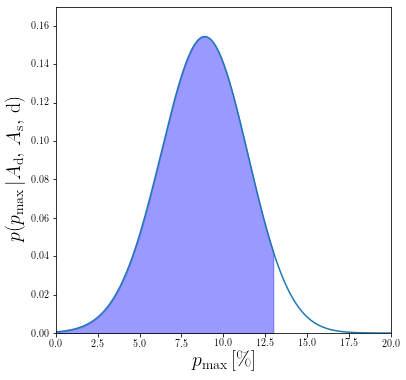

In [26]:
t_err   = []
t_amps  = []
t_freqs = []
for i in range(len(dust_Q_means)):
    if dust_P_means[i] != 0.0:
        t_amps.append(dust_Q_means[i])
        t_err.append(dust_Q_std[i])
        t_freqs.append(freq[i])

# t_amps.append(dust_Q_means[0])
# t_err.append(dust_Q_std[0])
# t_freqs.append(freq[0])

# t_amps.append(dust_Q_means[3])
# t_err.append(dust_Q_std[3])
# t_freqs.append(freq[3])
        
print(t_amps)        
print(t_err)
print(t_freqs)

# if (t_d_std != 0.0):
T_d = t_d_mean #np.linspace(19.5,19.7,100)
# else:
#     T_d = np.linspace(t_d_mean-t_d_std,t_d_mean+t_d_std,100)
if (beta_d_std != 0.0):
    beta_d = np.linspace(beta_d_mean-beta_d_std,beta_d_mean+beta_d_std,100)
else:
    beta_d = beta_d_mean
pmax  = np.linspace(0,22,1000)
vals  = np.empty(1000)
vals  = 0.0

for i in range(100):
    vals += fit_ame_2_amps(spdust_tot,mbb(1.0,353.,x,T_d,beta_d[i]),x,t_amps,t_freqs,t_err)

norm  = np.trapz(vals,pmax)    
cumul = np.cumsum(vals)    
dummy = np.empty(1000)
xfill = np.where(cumul/cumul[-1] < 0.95)[-1]
dummy[:] = 0.0    

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pmax,vals/norm)
ax.set_xlabel(r'$p_{\rm max}\, [{\rm \%}]$',size=20)
ax.set_ylabel(r'$p(p_{\rm max}\,|A_{\rm d},\,A_{\rm s},\,{\rm d})$',size=20)
ax.set_xlim([0,20])
ax.set_ylim([0,1.1*np.max(vals/norm)])
ax.fill_between(pmax[:xfill[-1]],dummy[:xfill[-1]],vals[:xfill[-1]]/norm,color='blue',alpha=0.4,label=r'${\rm 95\,\%\, Confidence\, Interval}$')
plt.savefig('../'+dir+'/P_amp_bestfit_posterior_w_sed_'+version+'.pdf',dpi=300,bbox_inches='tight')
plt.show()

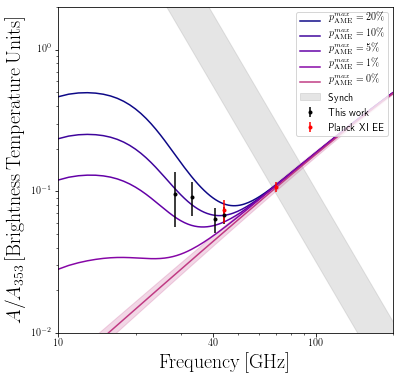

In [27]:
plot_SED()

In [ ]:
def sim_data(freqz):
    ame = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
    ame = ame/np.max(ame)*ame_over_353_mean
    sp_amp = np.interp(freqz,x,ame)
    print('Frequency',freqz)
    print('Thermal',mbb(1.0,353.,freqz,19.6,1.53))
    print('AME 22%',sp_amp)
    print('Synch',power_law(1.0,30.0,freqz,-3.1))
    print('')
    plt.loglog(x,ame)
    plt.scatter(freq,dust_Q_means,label='This work',color='k',zorder=10)
    plt.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10)
    plt.ylim([1e-3,1e3])
    plt.loglog(x,power_law(1.0,30.0,x,-3.1))
    plt.loglog(x,mbb(1.0,353.,x,19.6,1.53))
    plt.show()

In [ ]:
# print(cmb_to_rj(33.0,1.0))
sim_data(28.4)
sim_data(44.1)
sim_data(70.3)
sim_data(33.0)
sim_data(40.6)
# print(freq)
# sim_data(30.)
# sim_data(45.)
# sim_data(70.)
# sim_data(100.)